# CNN CLASSIFIER - ResNet18 (WIFI CSI SIGNAL)

In [1]:
# Section 1: Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-08-02 11:27:39.344748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Section 2: Data Preprocessing
dataset_path = 'Room2_npy'
target_length = 7500  
num_subcarriers = 90  

data_list = []
labels_list = []

classes_to_double = ["kneel", "liedown", "pickup"]

for activity_folder in os.listdir(dataset_path):
    activity_path = os.path.join(dataset_path, activity_folder)
    if os.path.isdir(activity_path):
        for participant_file in os.listdir(activity_path):
            participant_path = os.path.join(activity_path, participant_file)
            if os.path.isfile(participant_path) and participant_file.endswith('.npy'):
                data = np.load(participant_path)

                data = np.real(data)
                
                min_val = np.min(data)
                max_val = np.max(data)
                data_normalized = (data - min_val) / (max_val - min_val) if max_val != min_val else data
                
                if data_normalized.shape[0] > target_length:
                    data_normalized = data_normalized[:target_length]
                
                data_list.append(data_normalized)
                
                label = activity_folder
                if label in classes_to_double:
                    data_list.append(data_normalized)  
                    labels_list.append(label)  
                
                labels_list.append(label)  

data_list *= 5
labels_list *= 5

data = np.array(data_list)
labels = np.array(labels_list)

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))


In [3]:
# Section 3: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.219, random_state=42)

In [4]:
# Section 4: Model Definition
def simplified_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(32, 7, strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(64, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer=l2(1e-4))(x)
    
    model = Model(inputs, x)
    return model


In [5]:
# Section 5: Model Compilation and Training
input_shape = (7500, 90)
num_classes = y_train.shape[1]

model = simplified_model(input_shape, num_classes)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=15, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7500, 90)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3750, 32)       │        20,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3750, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3750, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3750, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3750, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3750, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 3750, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3750, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3750, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3750, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3750, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3750, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,711 (237.15 KB)

 Trainable params: 60,263 (235.40 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 999ms/step - accuracy: 0.2054 - loss: 1.9761 - val_accuracy: 0.1729 - val_loss: 2.5328 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4209 - loss: 1.6557 - val_accuracy: 0.1729 - val_loss: 3.0691 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 946ms/step - accuracy: 0.5660 - loss: 1.3920 - val_accuracy: 0.1729 - val_loss: 2.5357 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 936ms/step - accuracy: 0.6243 - loss: 1.2266 - val_accuracy: 0.2256 - val_loss: 2.3483 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 964ms/step - accuracy: 0.6737 - loss: 1.0836 - val_accuracy: 0.1579 - val_loss: 3.6387 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6704 - loss: 0.9254 - val_accuracy: 0.1579 - val_loss: 2.8587 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7444 - loss: 0.7786 - va

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
3/3 - 1s - 176ms/step - accuracy: 0.9265 - loss: 0.2914
Test loss: 0.2914
Test accuracy: 92.65%


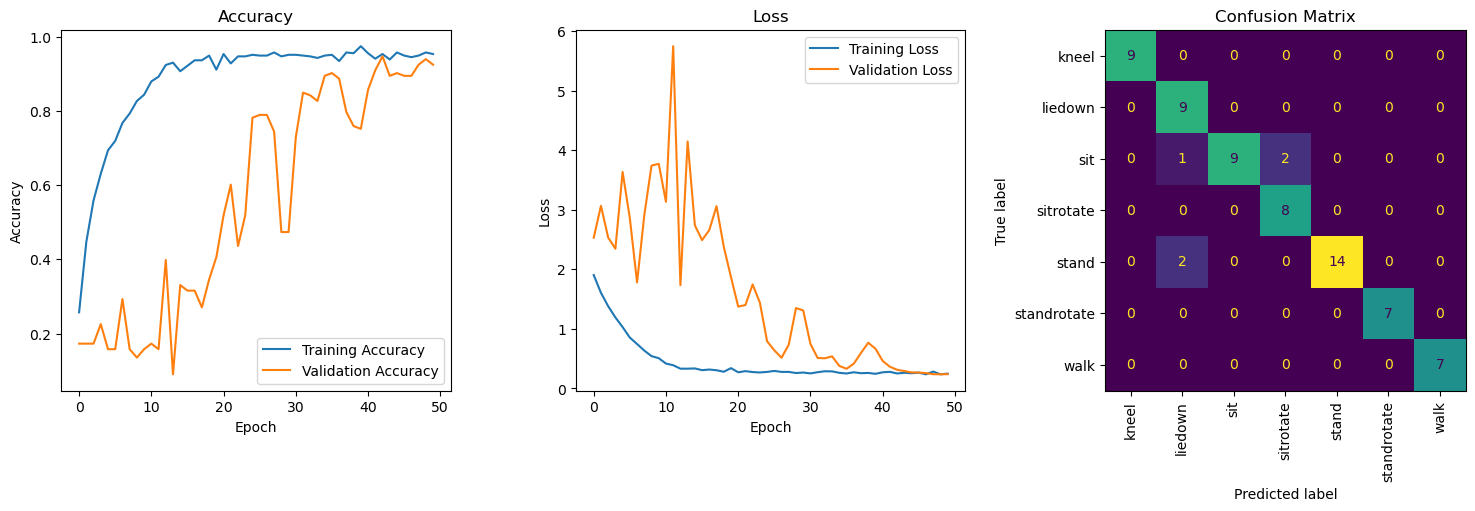

In [6]:
# Section 6: Model Evaluation
def performance_plot(history, model, test_images, test_labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

    # Plot Accuracy
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')

    # Plot Loss
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    # Generating predictions and plot Confusion Matrix
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(true_classes, predicted_classes)

    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f'Test loss: {test_loss:.4f}')
    print(f'Test accuracy: {test_acc*100:.2f}%')
    
    class_labels = encoder.categories_[0]  # Get class labels from the encoder
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(include_values=True, cmap='viridis', ax=axs[2], xticks_rotation='vertical', colorbar=False)
    axs[2].set_title("Confusion Matrix")
    
    plt.tight_layout()
    plt.show()

performance_plot(history, model, X_test, y_test)